# Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from IPython.display import Image  
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.base import is_classifier, is_regressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import seaborn as sns
plt.rcParams["figure.dpi"] = 75



def kaggle_score(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred));
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Partial Dependence Plots (PDPs)

Sometimes we might want to understand the effect of a single feature on the target variable. In particular how does the target variable change as the input variable changes (increases and decreases)? Note that feature importance scores do not answer this question. 

If we have the true function relating x to y then we can fulfill this aim. The function can be simple, complex or multivariate.

If $y = x$, then it is easy to describe the behavior of y as x changes: there is a positive linear relationship. What about $y = x + x^2 + 20x^3 - x^4$? 

Well, the derivative of y with respect to x is not the same for all values of x which means that the behavior of y as x changes differs depending on the value of x. 

When we have two variables we can still use visualization (contour or mesh plots) in order to understand the effect of the change in the variables on the output variable. However, for higher dimensional functions visualization is not possible. One possible solution is called Partial Dependendence Plots (PDPs) proposed by Friedman (2001) in his seminal gradient boosting machines paper. The reason was that, gradient boosting, unlike single decision trees, create models consisting of many trees (sometimes hundreds of trees). And it is almost impossible to understand the function represented by these trees. 

Suupose that we have $n$ variables $X = {x_1, x_2, ..., x_n}$ and $X_S = {x_1, x_2, ..., x_l}$ and $X_C = X  \backslash  X_S$. Then the partial dependence of the response $f$ at a point $X_S$ is given by:
$$
pd(X_S) = E_{X_C}[f(X_S, X_C)] = \int f(X_S,X_C)dP(X_C)
$$

We can estimate the function as follows:

$$
pd(X_S) = \frac{1}{m}\sum_{i=1}^mf(X_S,X_C^{(i)})
$$

where $m$ is the number of examples in the data set. 

PDPs show us the expected value of the target variable as a function of the input features $X_S$. For visualization, the size of $X_S$ can be at most 3 features. 




In [2]:
def my_partial_dependence_plot(model, data, feature_idx, n_points=100, categorical=False, percentiles=(0.05,0.95), kind="average", target=1, alpha = 0.3, subsample=50):
    X = data.copy()
    
    f = X.iloc[:,feature_idx]
    if categorical == False:
        min_value = np.percentile(f,100*percentiles[0])
        max_value = np.percentile(f,100*percentiles[1])
    #print(min_value, max_value)

    if (len(f.unique()) < n_points):
        x_range = np.sort(f.unique())
    else:
        step_size = (max_value-min_value)/n_points
        x_range = range(int(min_value), int(max_value), int(step_size))
        
    range_length = len(x_range)
    avgs = []
    inds = np.zeros((len(f),range_length))
    x = []
    if categorical == False:
        f = f[(f>=min_value) & (f<=max_value)]
    
    x_idx=0
    for i in x_range:
        # set all the column values to i and make predictions. This generates the response of the model for
        # all variations of the other features' values that are in the dataset.
        X.iloc[:,feature_idx] = i
        if (is_classifier(model)):
            preds = model.predict_proba(X)[:,target]
        else:
            preds = model.predict(X)
        avgs.append(np.mean(preds))
        inds[:,x_idx]=preds
        x.append(i)
        x_idx += 1
    if kind=="average" or kind=="both":
        plt.plot(x,avgs)
    if kind=="individual" or kind=="both":
        ice_lines_idx = random.sample(range(inds.shape[0]),subsample)
        for i in ice_lines_idx:
            plt.plot(x,inds[i],color="k",linewidth=0.5, alpha=alpha)
    ax = plt.gca()
    diff = max(avgs) - min(avgs)
    if categorical == False:
        deciles = np.percentile(f, np.arange(0, 100, 10))
        ax.vlines(deciles, min(avgs), min(avgs)+diff*0.05,color="k")
    #plt.ylim(min(avgs), max(avgs))
    plt.xlabel(X.columns[feature_idx])


### Census Income Dataset

In [3]:
adult = pd.read_csv("../../datasets/adult/adult.csv", delimiter=",", skipinitialspace=True)
adult = adult.drop(columns=['fnlwgt'])
print("Adult Shape:", adult.shape)
adult.head(5)

Adult Shape: (32561, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
numerical_features = ["age","education-num","capital-gain","capital-loss"]
categorical_features = adult.columns.drop(numerical_features).drop('y')


In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'hours-per-week', 'native-country'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['age', 'education-num', 'capital-gain',
                                  'capital-loss'])],
                  verbose_feature_names_out=False)

In [26]:
X = adult.drop(columns='y')
y = adult.loc[:,'y']
y = y.replace(["<=50K",">50K"],[0,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = make_pipeline(
    preprocessor,
    #DecisionTreeClassifier(max_depth=4),
    HistGradientBoostingClassifier(
        categorical_features=categorical_features, random_state=0
    ),
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2427
           1       0.80      0.64      0.71       830

    accuracy                           0.87      3257
   macro avg       0.84      0.79      0.81      3257
weighted avg       0.86      0.87      0.86      3257



In [7]:
X.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

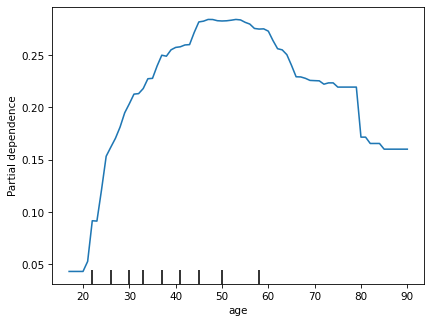

In [27]:
#partial_dependence(model, features=[0], X=X)
PartialDependenceDisplay.from_estimator(model, X, features=[0])


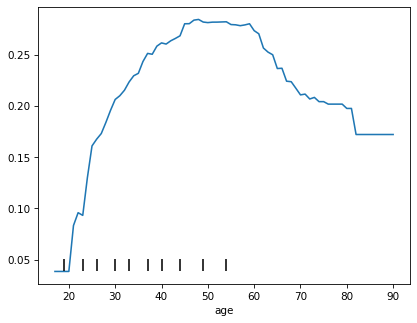

In [9]:
my_partial_dependence_plot(model, X, 0, kind="average")

In the above plots we can see that, as age increases, first there is an upward trend then around 50 decline begins. This is shape is quite reasonable.

For categorical features you need to specify which features are categorical then display will show bar charts for those features.

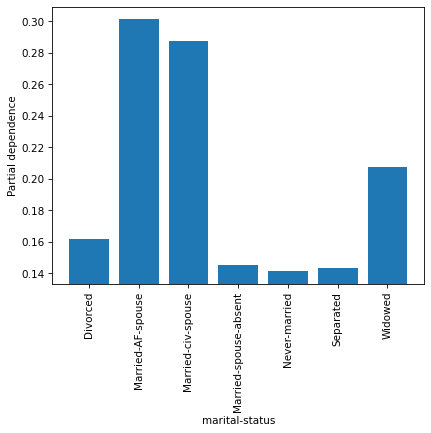

In [10]:
PartialDependenceDisplay.from_estimator(model, X, features=[4], categorical_features=[4])

In [11]:
X.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

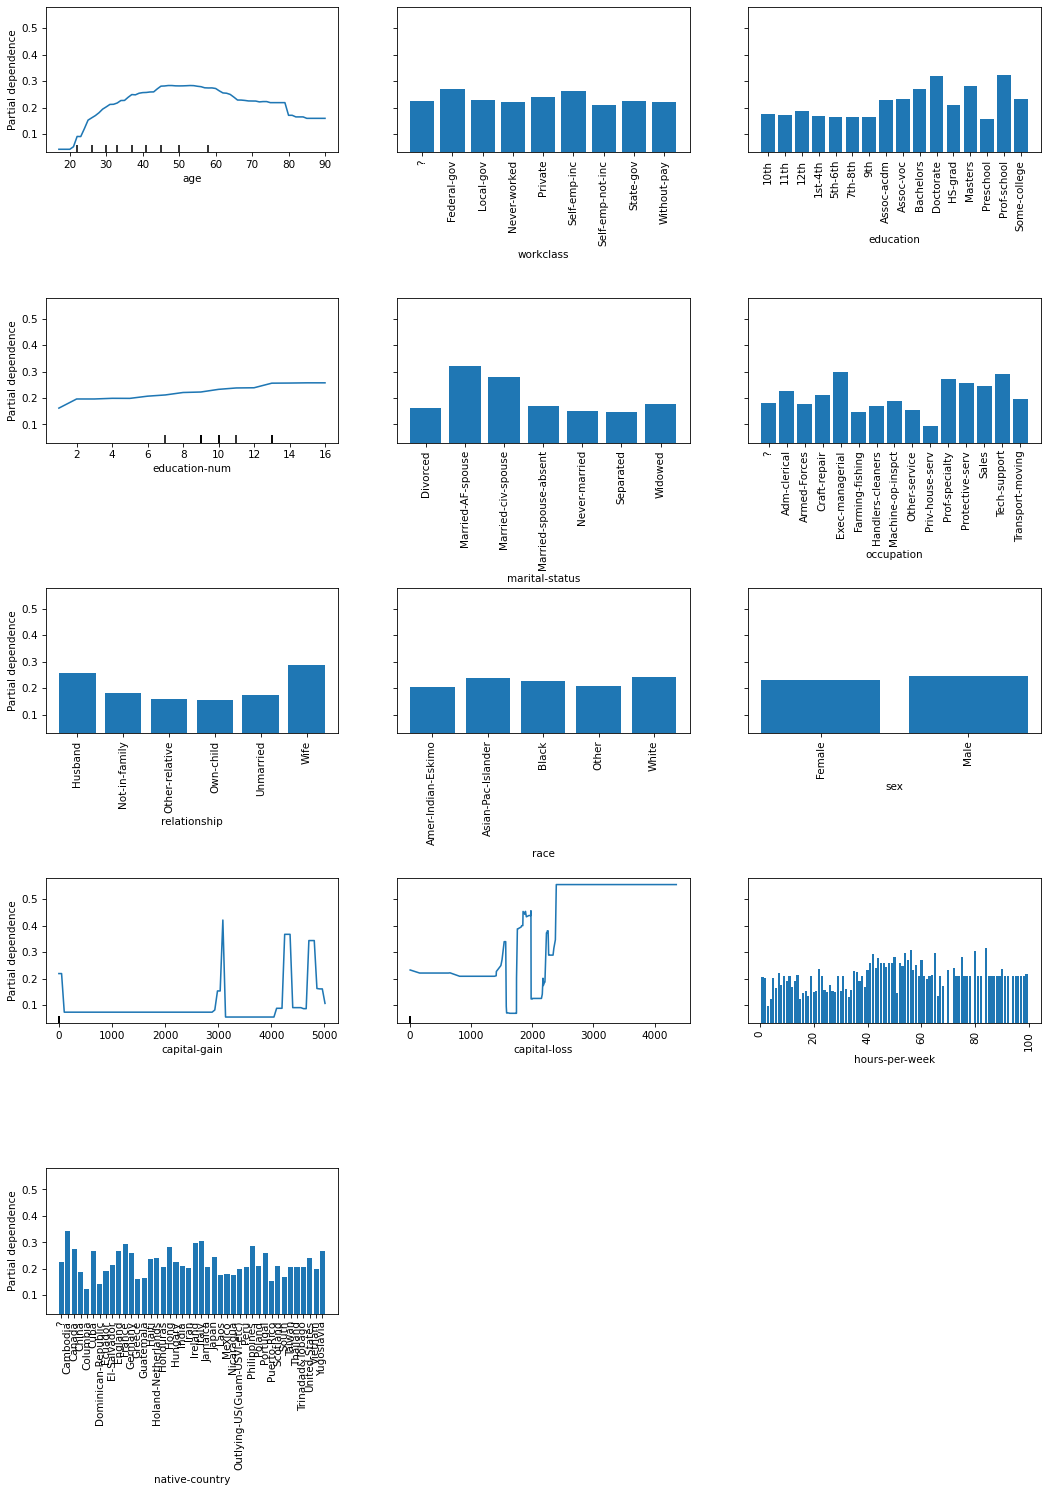

In [28]:
fig, ax = plt.subplots(figsize=(14, 18))
fig.tight_layout() 
fig.subplots_adjust(hspace=1)
PartialDependenceDisplay.from_estimator(model, X, features=X.columns, categorical_features=categorical_features, ax = ax)

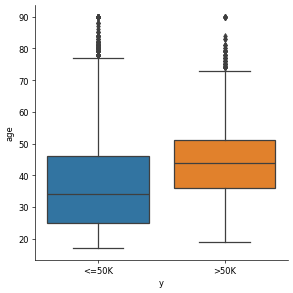

In [26]:
sns.catplot(x='y', y='age', kind="box", data=adult);

In [5]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
#bank = pd.read_csv("bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [309]:
X = bank.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
model = RandomForestClassifier()
model.fit(X_train, y_train);

y_pred1 = model.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3980
           1       0.68      0.21      0.33       542

    accuracy                           0.89      4522
   macro avg       0.79      0.60      0.63      4522
weighted avg       0.88      0.89      0.87      4522



In [8]:
def foo(x):
    return x + x**2 + 20*x**3 - x**4

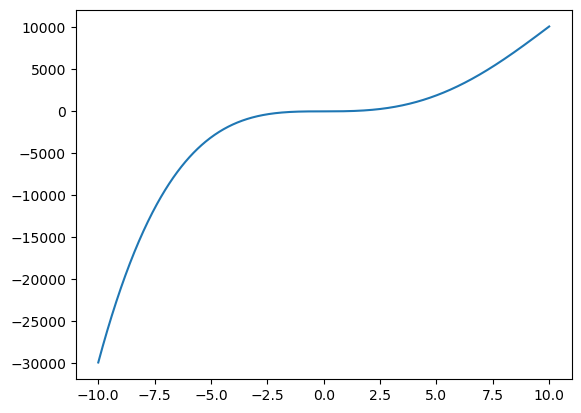

In [9]:
x = np.linspace(-10, 10, 1000)
y = foo(x)
plt.plot(x, y);

How can a similar plot can be drawn for the following multivariate function? That is, how can we plot how y varies as we vary x?

In [10]:
def foo2(x,y,z):
    return x + y**2 + 20*x**3 - y**4

### Regression Problem - Bike Sharing Dataset

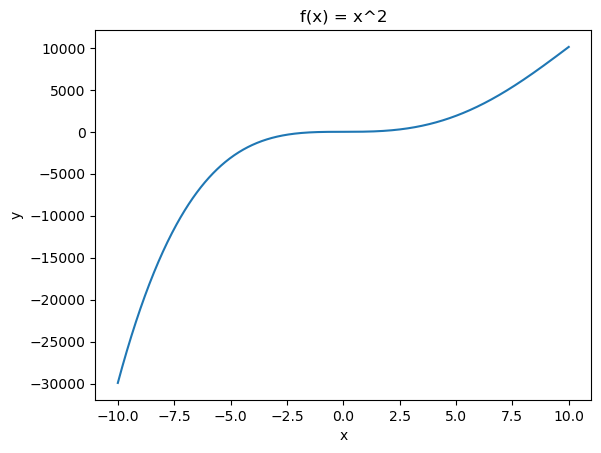

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function you want to plot
def f(x):
    return x**2

# Generate some x values to plot over
x = np.linspace(-10, 10, 1000)

# Evaluate the function for each x value
y = foo(x)

# Plot the function
plt.plot(x, y)

# Add labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x) = x^2')

# Show the plot
plt.show()


In [123]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target


In [124]:
X.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0


In [125]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [126]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

In [127]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [128]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [129]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)


In [130]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

In [131]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features, random_state=0
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.467s
Test R2 score: 0.64


In [132]:
X_test

,season,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
8645,spring,1,0,False,0,False,clear,14.76,18.940,0.66,0.0000
8646,spring,1,1,False,0,False,clear,14.76,17.425,0.66,8.9981
8647,spring,1,2,False,0,False,clear,13.12,17.425,0.76,0.0000
8648,spring,1,3,False,0,False,clear,12.30,16.665,0.81,0.0000
8649,spring,1,4,False,0,False,clear,11.48,15.150,0.81,6.0032
...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


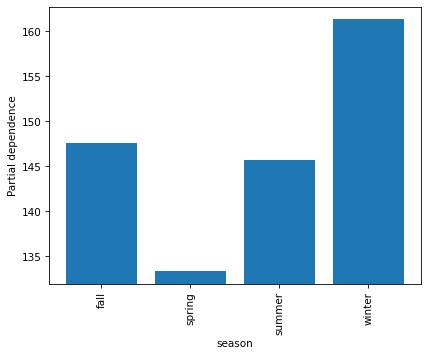

In [50]:
PartialDependenceDisplay.from_estimator(hgbdt_model, X, features=[0], categorical_features=[0])

In [46]:
X_train.columns

Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'feel_temp', 'humidity', 'windspeed'],
      dtype='object')

Computing partial dependence plots...
done in 7.399s


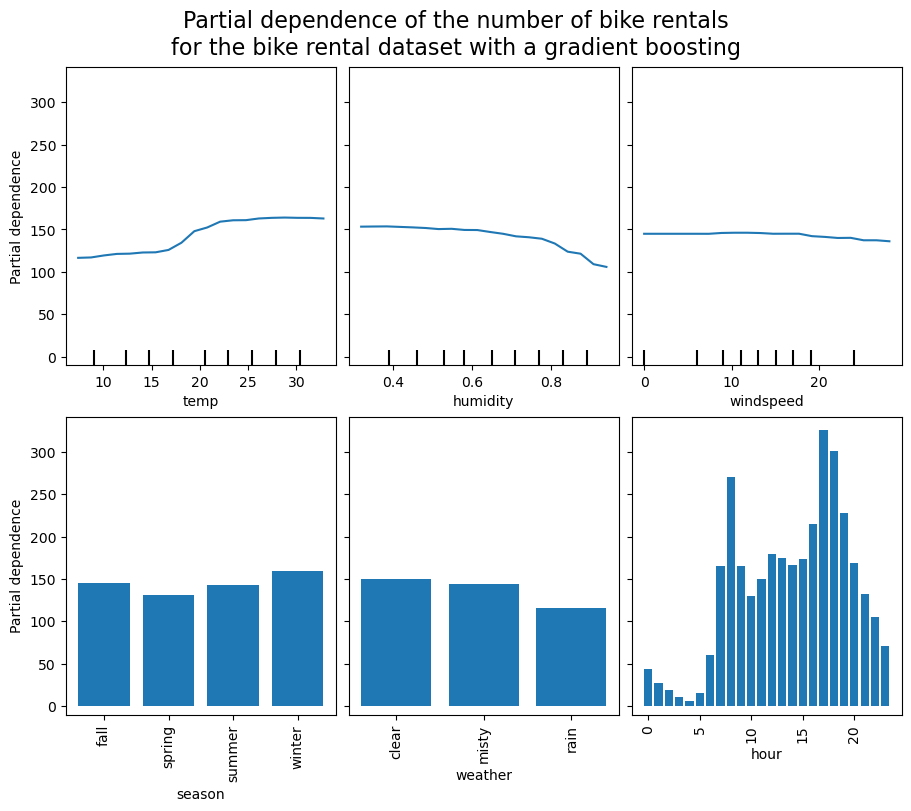

In [31]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with a gradient boosting",
    fontsize=16,
)

Computing partial dependence plots and individual conditional expectation...
done in 1.635s


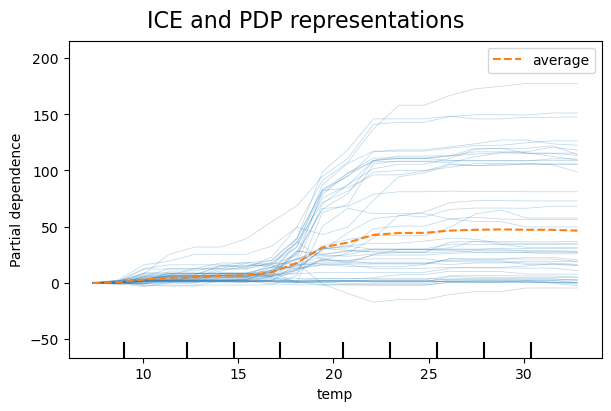

In [32]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(ncols=1, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": ["temp"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

In [28]:
A = X_train.copy()
MyPartialDependencePlot(hgbdt_model, A, 9, 100, kind="average")

NameError: name 'hgbdt_model' is not defined

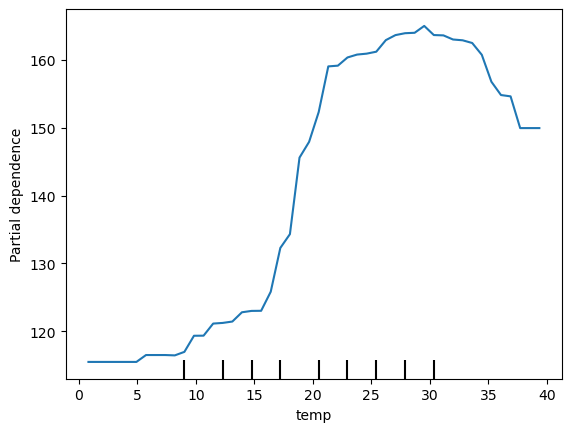

In [35]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[7], kind='average');

TypeError: cannot unpack non-iterable NoneType object

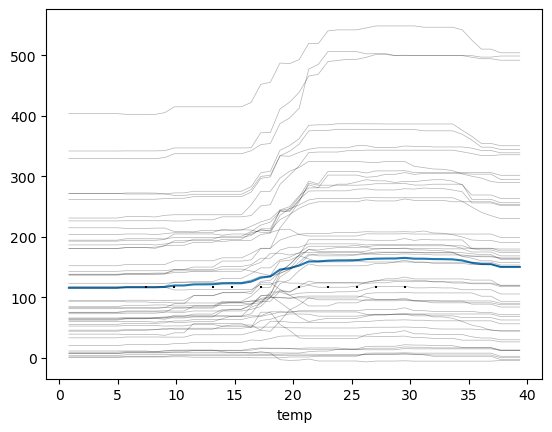

In [36]:
A = X_train.copy()
x, inds = MyPartialDependencePlot(hgbdt_model, A, 7, 100, kind="both")

In [ ]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[7], subsample= 50,centered=False,kind='both', random_state=0);

In [ ]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[0], categorical_features=[0]);

In [ ]:
MyPartialDependencePlot(hgbdt_model,X_train,0, categorical=True);

In [ ]:
X.head(5)

In [ ]:
PartialDependenceDisplay.from_estimator(clf,X_train,[0], target=1);

In [28]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

# We use only a subset of the data to speed up the example.
X = X.iloc[::5, :]
y = y[::5]

In [29]:
X["weather"].value_counts()


clear         2284
misty          904
rain           287
heavy_rain       1
Name: weather, dtype: int64

In [30]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)


In [31]:
X["year"].value_counts()


1    1747
0    1729
Name: year, dtype: int64

In [32]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [33]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 0 to 8640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      1729 non-null   category
 1   month       1729 non-null   int64   
 2   hour        1729 non-null   int64   
 3   holiday     1729 non-null   category
 4   weekday     1729 non-null   int64   
 5   workingday  1729 non-null   category
 6   weather     1729 non-null   category
 7   temp        1729 non-null   float64 
 8   feel_temp   1729 non-null   float64 
 9   humidity    1729 non-null   float64 
 10  windspeed   1729 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 115.4 KB


In [34]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
mlp_preprocessor


ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])

In [36]:
from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)